In [21]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
import math
import datetime
import networkx as nx
import os

In [22]:
def TodaysDate():
        
    Today = datetime.date.today()
    TodaysDate = Today.strftime('%d%b%Y')
    
    return TodaysDate

In [23]:
def DNACodingSequence(DNASequence, QualityScoreSequence, StartSequence, StopSequence):
#utilises ONLY ONE StopSequence, returns ONLY ONE CodingSequence
    
    QualityScoreString = """!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"""
    ThresholdQualityScore = 29 # ThresholdQualityScore must be between 0 and 93
    ThresholdQualityString = QualityScoreString[ThresholdQualityScore:]
    
    MinLength = 24
    MaxLength = 240
            
    StartIndex = DNASequence.find(StartSequence) + len(StartSequence)
    StopIndex = DNASequence.rfind(StopSequence)
    CodingSequence =  DNASequence[StartIndex:StopIndex]
    if MinLength <= len(CodingSequence) and len(CodingSequence) <= MaxLength and len(CodingSequence)%3 == 0:
        for Character in QualityScoreSequence[StartIndex:StopIndex]:
            if Character not in ThresholdQualityString:
                return None
        return str(CodingSequence)

In [24]:
def Translation(CodingSequence):
#translates DNA sequence

    TranslationCode = {
                    'AAA':'K','AAC':'N','AAG':'K','AAU':'N',
                    'ACA':'T','ACC':'T','ACG':'T','ACU':'T',
                    'AGA':'R','AGC':'S','AGG':'R','AGU':'S',
                    'AUA':'I','AUC':'I','AUG':'M','AUU':'I',
                    
                    'CAA':'Q','CAC':'H','CAG':'Q','CAU':'H',
                    'CCA':'P','CCC':'P','CCG':'P','CCU':'P',
                    'CGA':'R','CGC':'R','CGG':'R','CGU':'R',
                    'CUA':'L','CUC':'L','CUG':'L','CUU':'L',
                    
                    'GAA':'E','GAC':'D','GAG':'E','GAU':'D',
                    'GCA':'A','GCC':'A','GCG':'A','GCU':'A',
                    'GGA':'G','GGC':'G','GGG':'G','GGU':'G',
                    'GUA':'V','GUC':'V','GUG':'V','GUU':'V',
                    
                    'UAA':'#','UAC':'Y','UAG':'*','UAU':'Y',
                    'UCA':'S','UCC':'S','UCG':'S','UCU':'S',
                    'UGA':'&','UGC':'C','UGG':'W','UGU':'C',
                    'UUA':'L','UUC':'F','UUG':'L','UUU':'F'
                        }
    # UAA (ochre) — #
    # UAG (amber) — *
    # UGA (opal) — &
                    
    TranscriptionCode = {'A':'A','C':'C','G':'G','T':'U','U':'T'}
      
    RNASequence = ''
    for Nucleotide in CodingSequence:
        RNASequence += TranscriptionCode.get(Nucleotide,'X')
    #converts DNA to RNA
    #print RNASequence
        
    Peptide = ''
    while len(RNASequence) != 0:
        Peptide += TranslationCode.get(RNASequence[0:3],'Do not fuck with me!')
        RNASequence = RNASequence[3:]
    return Peptide

In [25]:
def SingleSelectionRoundSummary(fastqFileLocation):
#returns a list of lists with peptide-sequences and their frequencies, sorted by frequency in descending order
    
    RawDataFile = open(fastqFileLocation, 'r')
    Lines = RawDataFile.readlines()
    RawDataFile.close
    
    #StartSequence = 'ATG' # Met codon
    #StopSequence = 'TGCGGCAGC'# Akane seams to have trimmed siquences
    #StopSequence = 'TAG' # amber stop codon
    
    StartSequence = 'TAATACGACTCACTATAGGGTTAACTTTAAGAAGGAGATATACATATG'    # NNK - T7g10M.F48 
    StopSequence = 'TGCGGCAGCGGCAGCGGCAGCTAGGACGGGGGGCGGAAA' #NNK - CGS3an13.R39 
    #StartSequence = 'TAATACGACTCACTATAGGGTTGAACTTTAAGTAGGAGATATATCCATG'   #NNU - T7-CH-F49
    #StopSequence = 'TGTGGGTCTGGGTCTGGGTCTTAGGACGGGGGGCGGAAA'  #NNU - CGS3-CH-R39
    
    SingleSelectionRoundSummary = {}
    #creates empty SingleSelectionRoundSummary dictionary to store the results from a single round of selection
    #SingleSelectionRoundSummary = {PeptideY:    {CodingSequence_YZ:    Occurence_YZ}}
        
    #populates SingleSelectionRoundSummary dictionary with the results from a single round of selection
    for i,Line in enumerate(Lines):
        if StartSequence in Line and StopSequence in Line:
            CodingSequence = DNACodingSequence(Line, Lines[i + 2], StartSequence, StopSequence)
            if CodingSequence != None:
                PeptideSequence = Translation(CodingSequence)
                if PeptideSequence not in SingleSelectionRoundSummary:
                    SingleSelectionRoundSummary[str(PeptideSequence)] = {str(CodingSequence) : 1}
                else:
                    if CodingSequence not in SingleSelectionRoundSummary[str(PeptideSequence)]:
                        SingleSelectionRoundSummary[str(PeptideSequence)][str(CodingSequence)] = 1
                    else:
                        SingleSelectionRoundSummary[str(PeptideSequence)][str(CodingSequence)] += 1

    return SingleSelectionRoundSummary

In [26]:
def HammingDistance(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '%'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '%'
    
    HammingDistance = 0
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            HammingDistance = HammingDistance
        else:
            HammingDistance = HammingDistance + 1
            
    return HammingDistance

In [27]:
def HammingDistanceBasedFormating(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '-'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '-'
    
    HammingDistance = 0
    FormatedSequence2 = ''
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            FormatedSequence2 += Sequence2[i].lower()
            HammingDistance = HammingDistance
        else:
            FormatedSequence2 += Sequence2[i]
            HammingDistance = HammingDistance + 1            
    return FormatedSequence2

In [28]:
def CompleteSelectionSummary(fastqDataFolderLocation):
# returns a SelectionSummary dictionary with the following structure
# SelectionSummary = {SelectionRound_X:    {PeptideXY:    {CodingDNA_XYZ:    Occurence_XYZ}}}

    CompleteSelectionSummary = {}
    # creates empty SelectionSummary dictionary to store the results from all the rounds of selection

    for file in os.listdir(fastqDataFolderLocation):
        
        FileLocation = os.path.join(fastqDataFolderLocation, file)
          
        if file.endswith('.fastq'): # this conditional is necessary; without it some shit appears in the beginning of the file list
            RoundNumberFirstDigit = file[file.find('.')-2]
            RoundNumberSecondDigit = file[file.find('.')-1]
            if RoundNumberFirstDigit == '0':
                RoundNumber = int(RoundNumberSecondDigit)
                #print RoundNumber
            elif RoundNumberFirstDigit != '0':
                RoundNumber = int(file[file.find('.')-2 : file.find('.')])
                #print RoundNumber
        #(1.A) extracts the round number from the file name (file name should have two digit number before full stop — '00.') 
                
            SelectionRoundSummary = SingleSelectionRoundSummary(FileLocation)
            #(1.B) extracts single round results 
                    
            CompleteSelectionSummary[RoundNumber] = SelectionRoundSummary
            #(1.C) populate ConcatenatedResultsList
            #print ConcatenatedResultsList
            
    return CompleteSelectionSummary

In [29]:
def PeptidesOccurences_BY_Round(fastqDataFolderLocation):
    SelectionSummary = CompleteSelectionSummary(fastqDataFolderLocation)
    
    PeptidesOccurences_BY_Round = {}
    for Round in SelectionSummary:
        PeptidesOccurences_IN_Round = {}
        for Peptide in SelectionSummary[Round]:
            PeptidesOccurences_IN_Round[Peptide] = sum(SelectionSummary[Round][Peptide].values())
        PeptidesOccurences_BY_Round[Round] = PeptidesOccurences_IN_Round
        
    return PeptidesOccurences_BY_Round

In [30]:
def DNAsOccurences_BY_Round(fastqDataFolderLocation):
    SelectionSummary = CompleteSelectionSummary(fastqDataFolderLocation)
    
    DNAsOccurences_BY_Round = {}
    for Round in SelectionSummary:
        DNAsOccurences_IN_Round = {}
        for Peptide in SelectionSummary[Round]:
            for DNA in SelectionSummary[Round][Peptide]:
                DNAsOccurences_IN_Round[DNA] = SelectionSummary[Round][Peptide][DNA]
        DNAsOccurences_BY_Round[Round] = DNAsOccurences_IN_Round

    return DNAsOccurences_BY_Round

In [31]:
def TotalReads_BY_Round(fastqDataFolderLocation):
    SelectionSummary = CompleteSelectionSummary(fastqDataFolderLocation)
    Peptides_BY_Round = PeptidesOccurences_BY_Round(fastqDataFolderLocation)
    
    TotalReads_BY_Round = {}
    for Round in SelectionSummary:
        TotalReads_BY_Round[Round] = sum(Peptides_BY_Round[Round].values())
        
    return TotalReads_BY_Round

In [32]:
def BaseRoundSortedPeptidesList(fastqDataFolderLocation, BaseRoundIndex):
    Peptides_BY_Round = PeptidesOccurences_BY_Round(fastqDataFolderLocation)  
            
    PeptidesOccurencesInBaseRound = Peptides_BY_Round[BaseRoundIndex]
    BaseRoundSortedPeptidesList = sorted(PeptidesOccurencesInBaseRound, key = PeptidesOccurencesInBaseRound.get, reverse = True)
    
    return BaseRoundSortedPeptidesList

In [33]:
def PeptidesRank_IN_BaseRound(fastqDataFolderLocation, BaseRoundIndex):
    Peptides_BY_Round = PeptidesOccurences_BY_Round(fastqDataFolderLocation)
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(fastqDataFolderLocation, BaseRoundIndex)
    
    BasePeptideCount = 0
    PeptideRank = 1
    
    PeptidesRank_IN_BaseRound = {}
    
    for Peptide in BaseRoundSortedPeptides:
        PeptideCount = Peptides_BY_Round[BaseRoundIndex][Peptide]
        if PeptideCount < BasePeptideCount:
            PeptideRank += 1
        
        PeptidesRank_IN_BaseRound[Peptide] = PeptideRank
        BasePeptideCount = PeptideCount
        
    return PeptidesRank_IN_BaseRound

In [34]:
def BaseRoundSortedDNAsList(fastqDataFolderLocation, BaseRoundIndex):
    DNAs_BY_Round = DNAsOccurences_BY_Round(fastqDataFolderLocation)  
            
    DNAsOccurences_IN_BaseRound = DNAs_BY_Round[BaseRoundIndex]
    BaseRoundSortedDNAsList = sorted(DNAsOccurences_IN_BaseRound, key = DNAsOccurences_IN_BaseRound.get, reverse = True)
    
    return BaseRoundSortedDNAsList

In [35]:
def DNAClonesOccurences_BY_Round_BY_Peptide(fastqDataFolderLocation):
    SelectionSummary = CompleteSelectionSummary(fastqDataFolderLocation)
    
    DNAClonesOccurences_BY_Round_BY_Peptide = {}
    for Round in SelectionSummary:
        DNAClonesOccurences_BY_Peptide = {}
        for Peptide in SelectionSummary[Round]:
            DNAClonesOccurences_BY_Peptide[Peptide] = len(SelectionSummary[Round][Peptide])
        DNAClonesOccurences_BY_Round_BY_Peptide[Round] = DNAClonesOccurences_BY_Peptide
        
    return DNAClonesOccurences_BY_Round_BY_Peptide

In [36]:
def PeptidesAppearances_BY_Round(BaseRoundSortedPeptidesList, PeptidesOccurences_BY_Round):
    
    PeptidesAppearances_BY_Round = {}
    
    for Peptide in BaseRoundSortedPeptidesList:
        PeptidesAppearances_BY_Round[Peptide] = []
        for Round in PeptidesOccurences_BY_Round:
            if Peptide in PeptidesOccurences_BY_Round[Round]:
                PeptidesAppearances_BY_Round[Peptide] += [Round]
    return PeptidesAppearances_BY_Round

In [37]:
def DNAsAppearances_BY_Round(BaseRoundSortedDNAsList, DNAsOccurences_BY_Round):
    
    DNAsAppearances_BY_Round = {}
    
    for DNA in BaseRoundSortedDNAsList:
        DNAsAppearances_BY_Round[DNA] = []
        for Round in DNAsOccurences_BY_Round:
            if DNA in DNAsOccurences_BY_Round[Round]:
                DNAsAppearances_BY_Round[DNA] += [Round]
    return DNAsAppearances_BY_Round

In [38]:
def AUCount(DNASequence):
    AUCount = 0
    
    for Nucleotide in range(len(DNASequence)):
        if DNASequence[Nucleotide] == 'A' or DNASequence[Nucleotide] == 'U' or DNASequence[Nucleotide] == 'T':
            AUCount += 1

    return AUCount

In [39]:
def SelectionSummaryReport(fastqDataFolderLocation, BaseRoundIndex, NumberOfTopPeptides, SelectionSummaryReportFileName):
    
    today = TodaysDate() 
    
    SelectionSummaryFileNameCSV = str(today) + 'SelectionSummary' + SelectionSummaryReportFileName + '.csv'
    SelectionSummaryReportFile = open(SelectionSummaryFileNameCSV, 'w')
    
    SelectionSummary = CompleteSelectionSummary(fastqDataFolderLocation)
    SortedRoundsList = sorted(SelectionSummary.keys())
    
    Peptides_BY_Round = PeptidesOccurences_BY_Round(fastqDataFolderLocation)
    TotalPeptides_BY_Round = TotalReads_BY_Round(fastqDataFolderLocation)
    
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(fastqDataFolderLocation, BaseRoundIndex)
    BaseRoundTopSortedPeptides = BaseRoundSortedPeptides[0 : (NumberOfTopPeptides)]
    
    AlaScanPeptidesKDs = {'VWDPRTFYLSRI' : '3', 'AWDPRTFYLSRI' : '8', 'VADPRTFYLSRI' : '413',
                        'VWAPRTFYLSRI' : '28', 'VWDARTFYLSRI' : '12', 'VWDPATFYLSRI' : '2',
                        'VWDPRAFYLSRI' : '12', 'VWDPRTAYLSRI' : '187', 'VWDPRTFALSRI' : '>1000',
                        'VWDPRTFYASRI' : '79', 'VWDPRTFYLARI' : '9', 'VWDPRTFYLSAI' : '468',
                        'VWDPRTFYLSRA' : '6'
                       }
    
    AlaScanPeptidescDNAs = {'VWDPRTFYLSRI' : 'GTTTGGGATCCGAGGACGTTTTATTTGTCTAGGATT',
                            'AWDPRTFYLSRI' : 'GCGTGGGATCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VADPRTFYLSRI' : 'GTGGCGGATCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWAPRTFYLSRI' : 'GTGTGGGCGCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWDARTFYLSRI' : 'GTGTGGGATGCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWDPATFYLSRI' : 'GTGTGGGATCCGGCGACCTTTTATCTGAGCCGCATT',
                            'VWDPRAFYLSRI' : 'GTGTGGGATCCGCGCGCGTTTTATCTGAGCCGCATT',
                            'VWDPRTAYLSRI' : 'GTGTGGGATCCGCGCACCGCGTATCTGAGCCGCATT',
                            'VWDPRTFALSRI' : 'GTGTGGGATCCGCGCACCTTTGCGCTGAGCCGCATT',
                            'VWDPRTFYASRI' : 'GTGTGGGATCCGCGCACCTTTTATGCGAGCCGCATT',
                            'VWDPRTFYLARI' : 'GTGTGGGATCCGCGCACCTTTTATCTGGCGCGCATT',
                            'VWDPRTFYLSAI' : 'GTGTGGGATCCGCGCACCTTTTATCTGAGCGCGATT',
                            'VWDPRTFYLSRA' : 'GTGTGGGATCCGCGCACCTTTTATCTGAGCCGCGCG'
                                }
    
    BaseRoundPeptidesRank = PeptidesRank_IN_BaseRound(fastqDataFolderLocation, BaseRoundIndex)
    #print (BaseRoundSortedPeptides)
    #print (BaseRoundTopSortedPeptides)
    
    SelectionSummaryReportFile.write('peptide sequence' + ',')
    for Round in SortedRoundsList:
        SelectionSummaryReportFile.write('round # ' + str(Round) + ' occurence (#)' + ',')
    SelectionSummaryReportFile.write('\n')
    
    for Peptide in BaseRoundTopSortedPeptides:
        SelectionSummaryReportFile.write(Peptide + ',')
        for Round in SortedRoundsList:
            SelectionSummaryReportFile.write(str(Peptides_BY_Round[Round].get(Peptide, 0)) + ',')
        SelectionSummaryReportFile.write('\n')
        
    SelectionSummaryReportFile.write('total #' + ',')
    for Round in SortedRoundsList:
        SelectionSummaryReportFile.write(str(TotalPeptides_BY_Round[Round]) + ',')
    SelectionSummaryReportFile.write('\n\n\n')
    
    SelectionSummaryReportFile.write('peptide sequence' + ',')
    for Round in SortedRoundsList:
        SelectionSummaryReportFile.write('round # ' + str(Round) + ' fraction (%)' + ',')
    SelectionSummaryReportFile.write('\n')
    
    for Peptide in BaseRoundTopSortedPeptides:
        SelectionSummaryReportFile.write(Peptide + ',')
        for Round in SortedRoundsList:
            PeptideFraction = float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[Round])
            SelectionSummaryReportFile.write('{:.3%}'.format(PeptideFraction) + ',')
        SelectionSummaryReportFile.write('\n')
            
    SelectionSummaryReportFile.close()
        
#-------------------------------------------------------------------------------
   
    # Create a figure of size 8x6 inches, 500 dots per inch
    plt.figure(figsize = (8, 6),
               dpi = 500)
    # Create 'ggplot' style
    plt.style.use('fivethirtyeight')
    # Create a new subplot from a grid of 1x1
    Graph = plt.subplot(1, 1, 1)
    
    
    # Map colours onto lines
    # NumberOfTopPeptides was replaced with 15, to make gradient more pronounced
    cNorm  = matplotlib.colors.Normalize(vmin = 0,
                                         vmax = 15 - 1)
    scalarMap = matplotlib.cm.ScalarMappable(norm = cNorm,
                                             cmap = 'Paired')
        
    Xs = []
    Ys = []
    
    for Peptide in BaseRoundSortedPeptides:
        if Peptide in AlaScanPeptidesKDs:
            #print (Peptide)
    #for Peptide in BaseRoundTopSortedPeptides:
            PeptidesFractions_BY_Round = []
            for Round in SortedRoundsList:
                PeptidesFractions_BY_Round += [float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[Round])]

            x = SortedRoundsList
            y = PeptidesFractions_BY_Round
            Xs += x
            Ys += y


            # Format Peptide
            FormatedPeptide = ''
            for i in Peptide:
                if i != 'A':
                    FormatedPeptide += i.lower()
                else:
                    FormatedPeptide += i

            # Set PeptideColour
            #PeptideColour = scalarMap.to_rgba(BaseRoundTopSortedPeptides.index(Peptide))
            cDNA = AlaScanPeptidescDNAs[Peptide]
            cDNAATCount = AUCount(cDNA)
            cDNALabel = HammingDistanceBasedFormating('GTTTGGGATCCGAGGACGTTTTATTTGTCTAGGATT', cDNA)

            PeptideRank = str(BaseRoundPeptidesRank[Peptide])
            PeptideColour = scalarMap.to_rgba(PeptideRank)
            PeptideKD = AlaScanPeptidesKDs[Peptide]

            PeptideLabel = (FormatedPeptide + ' (' + PeptideRank + ', ' + PeptideKD +' nM)' +'\n' +
                            cDNALabel + ' (A/T count = ' + str(cDNAATCount) + ')')

            plt.plot(x, y,
                     'o-',
                     c = PeptideColour,
                     lw = 2.0,
                     ms = 4.0,
                     mew = 0.1,
                     mec = '#191919',
                     label = PeptideLabel)
    
    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
    plt.axis([XMin, XMax, YMin, YMax])
    
    plt.xticks([0, 1, 2],
               ['Input\nLibrary', 'Pre-Selection\nLibrary', 'Post-Selection\nLibrary'],
               fontsize = 10)
    #plt.xlabel('Selection Round #',
    #           fontsize = 10)
    
    plt.yticks([0.0, 0.2, 0.4, 0.6],
               fontsize = 10)       
    plt.ylabel('Peptide Fraction',
               fontsize = 10)
    
    legend = plt.legend(#BaseRoundTopSortedPeptides,
                        title = 'cyclic-peptide random region',
                        loc = 'upper center',
                        bbox_to_anchor = (0.5, -0.10),
                        fancybox = True,
                        shadow = False,
                        fontsize = 10,
                        ncol = 1)
    
    Graph.get_legend().get_title().set_size('small')
    
    SelectionSummaryFileNamePNG = str(today) + 'SelectionSummary' + SelectionSummaryReportFileName + '.png'
    
    plt.savefig(SelectionSummaryFileNamePNG,
                bbox_extra_artists = [legend],
                bbox_inches = 'tight',
                dpi = 300)
    plt.show()
    plt.close()

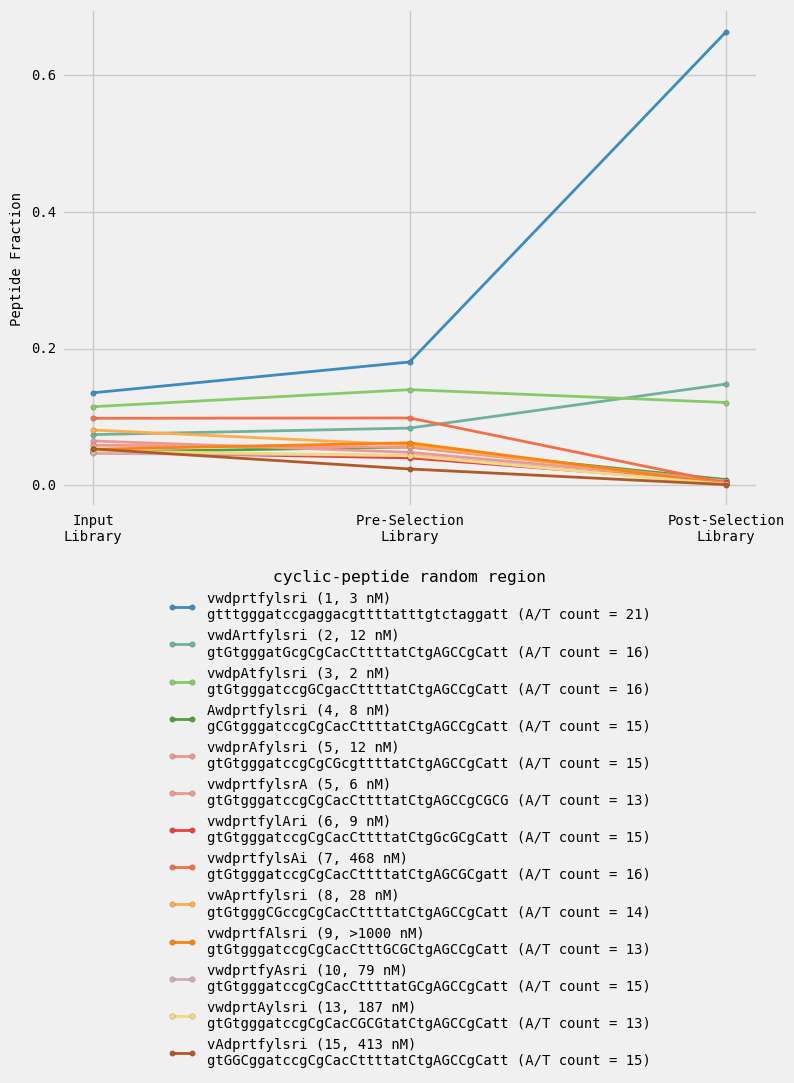

In [40]:
DataFolderLocation = '/Users/nikita/Documents/DataSequensing/SelectionBias/PHD2AlaScan/WithPreWashes II/SequencingResults'
BaseSelectionRoundNumber = 2
TopNPeptidesNumber = 100
SummaryFileName = 'Paper02_AlaScan_I'

SelectionSummaryReport(DataFolderLocation, BaseSelectionRoundNumber, TopNPeptidesNumber, SummaryFileName)